# Load the data and explore it

Load Data

In [1]:
# Load the dataset

import os

import pandas as pd
from pandas import plotting as pdplt

import numpy as np
from numpy import random

import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from itertools import combinations 

from itertools import starmap 
  

csvf = '.'+ os.path.sep +'data'+os.path.sep+ 'brainsize.csv'

data = pd.read_csv(csvf, sep=';', index_col=0, na_values=".")
data.head()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
1,Female,133,132,124,118.0,64.5,816932
2,Male,140,150,124,NaN,72.5,1001121
3,Male,139,123,150,143.0,73.3,1038437
4,Male,133,129,128,172.0,68.8,965353
5,Female,137,132,134,147.0,65.0,951545




Check general stadistics of our data.

In [2]:
data.describe()

,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
count,40.000000,40.000000,40.00000,38.000000,39.000000,4.000000e+01
mean,113.450000,112.350000,111.02500,151.052632,68.525641,9.087550e+05
std,24.082071,23.616107,22.47105,23.478509,3.994649,7.228205e+04
min,77.000000,71.000000,72.00000,106.000000,62.000000,7.906190e+05
25%,89.750000,90.000000,88.25000,135.250000,66.000000,8.559185e+05
50%,116.500000,113.000000,115.00000,146.500000,68.000000,9.053990e+05
75%,135.500000,129.750000,128.00000,172.000000,70.500000,9.500780e+05
max,144.000000,150.000000,150.00000,192.000000,77.000000,1.079549e+06


Let's check what data types we have 

In [3]:
data.dtypes

Gender        object
FSIQ           int64
VIQ            int64
PIQ            int64
Weight       float64
Height       float64
MRI_Count      int64
dtype: object

Data typese seems to make sense so we will not asert any of them for now 

We don't want to have NaN values in our data, before continuing, we will delete all of them.

In [4]:
dataf = data.dropna()
print('We lost a total of ', data.shape[0] - dataf.shape[0], 'subjects')

We lost a total of  2 subjects


We did not lose may subjects, so we will igonre any nan.

In [5]:
data = dataf

# Create our first very important variable base on very fine observations

One of our most interesting data we did not include in the previous csv was the **Time to Get from the Door to the Chair** (TGDC)  and also very intersting **Time to Get from the Chair to the Door** (TGCD).

Both are *measured* in seconds and are rounded to full seconds.

These where calculated using the hacked security system of our lab. 

Generate my for sure very interesting and correlated extra variable

In [6]:
distributions = [
    {"type": np.random.normal, "kwargs": {"loc": 80, "scale": 40}},
    {"type": np.random.normal, "kwargs": {"loc": 150, "scale": 30}},
    {"type": np.random.normal, "kwargs": {"loc": 300, "scale": 30}},
]
coefficients = np.array([0.4, 0.6, .2])
coefficients /= coefficients.sum()      # in case these did not add up to 1
sample_size = data.shape[0]

our_seed = 10000
np.random.seed(our_seed)
num_distr = len(distributions)
rdata = np.zeros((sample_size, num_distr))
for idx, distr in enumerate(distributions):
    rdata[:, idx] = distr["type"](size=(sample_size,), **distr["kwargs"])
random_idx = np.random.choice(np.arange(num_distr), size=(sample_size,), p=coefficients)
partY = rdata[np.arange(sample_size), random_idx]

our_seed = 9000000
np.random.seed(our_seed)
random_idx = np.random.choice(np.arange(num_distr), size=(sample_size,), p=coefficients)
partY2 = rdata[np.arange(sample_size), random_idx]

# Extra plots
# plt.hist(partY, density=True)
# plt.show()

# plt.hist(partY2, density=True)
# plt.show()

Enbedd our new super amazin varaliable in our dataframe

In [7]:
data.insert(2, "TGDC", partY, False) 
data.insert(2, "TGCD", partY2, False) 

Check that is inserted correctly

In [8]:
data.describe()

,FSIQ,TGCD,TGDC,VIQ,PIQ,Weight,Height,MRI_Count
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,3.800000e+01
mean,113.552632,144.029084,137.834643,112.131579,111.342105,151.052632,68.421053,9.067542e+05
std,23.815391,85.127818,88.420134,22.939605,22.597867,23.478509,3.993790,7.256175e+04
min,77.000000,25.235484,18.045814,71.000000,72.000000,106.000000,62.000000,7.906190e+05
25%,90.250000,85.857866,82.994283,90.250000,89.250000,135.250000,66.000000,8.548115e+05
50%,116.500000,131.686795,117.999616,113.000000,115.000000,146.500000,68.000000,9.053990e+05
75%,135.000000,168.996420,180.515331,129.000000,128.000000,172.000000,70.375000,9.495405e+05
max,144.000000,378.407493,330.155295,150.000000,150.000000,192.000000,77.000000,1.079549e+06


# Get an overview of our data 

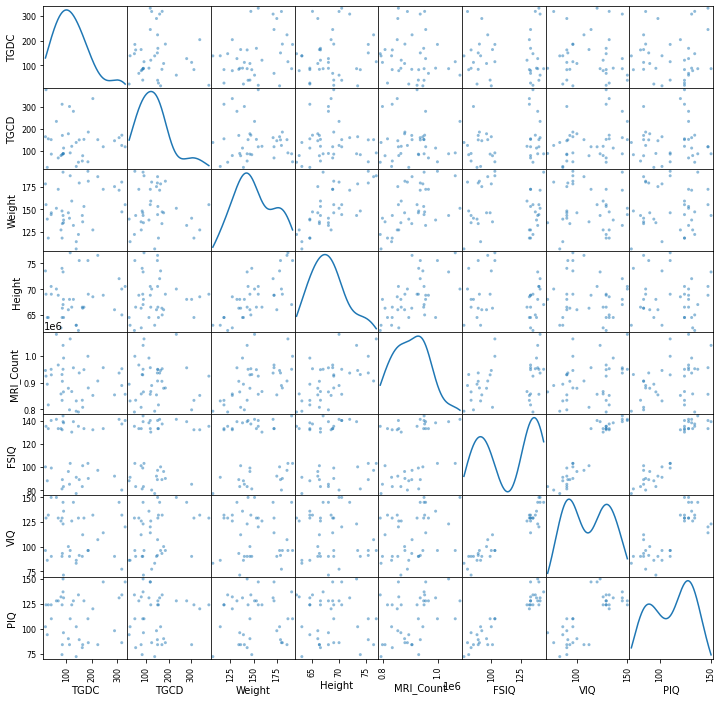

In [9]:
allvarsmtrx = pdplt.scatter_matrix(data[['TGDC', 'TGCD', 'Weight', 'Height', 'MRI_Count', 'FSIQ', 'VIQ', 'PIQ' ]], diagonal='kde', figsize=(12,12));

plt.savefig('fig' + os.path.sep + 'scatter_matrix.png', bbox_inches='tight')

Looking at the distributions we see that exploring Weight, MRI_Count and Height could be a good direction

Looking at PIQ         Slope:0.169      P-value:0.0433      R-squared:0.00187    
Looking at VIQ         Slope:-0.24      P-value:-0.0621     R-squared:0.00386    
Looking at FSIQ        Slope:-0.0517    P-value:-0.0139     R-squared:0.000194   
Looking at Weight      Slope:1.15       P-value:0.305       R-squared:0.0928     
Looking at MRI_Count   Slope:-0.000161  P-value:-0.132      R-squared:0.0175     
Looking at Height      Slope:2.32       P-value:0.105       R-squared:0.011      


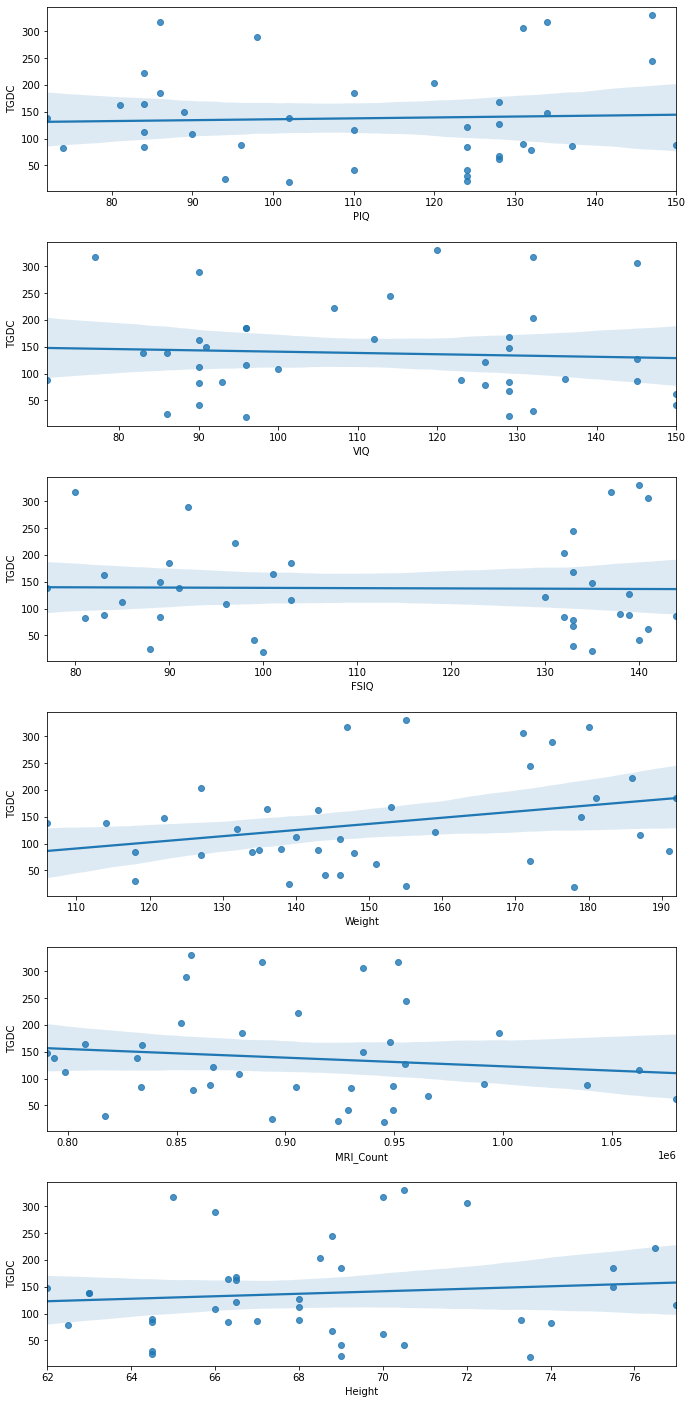

In [10]:
# sns.set(style="ticks")

to_explore = ['PIQ', 'VIQ', 'FSIQ', 'Weight', 'MRI_Count', 'Height']

f, axes = plt.subplots(len(to_explore), 1, figsize=(10,20))
ptl_idx = 0
f.tight_layout(pad=3.0)

for varN in to_explore:
    sns.regplot(data[varN], data.TGDC, ax=axes[ptl_idx])
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[varN], data.TGDC)
    print('Looking at {:<10}  Slope:{:<10.3} P-value:{:<10.3}  R-squared:{:<10.3} '.format(varN, slope , r_value, r_value**2))
    ptl_idx += 1

plt.savefig('fig' + os.path.sep + 'indivudual.png', bbox_inches='tight')

It seems that if we get rid of some big outliers we will be able to have a better result.

Also we confirm that Weight, MRI_Count and Height can be a good start.

We need to explore more our data.

We will use a combination algorithm to explore what are the best models to use.

In [11]:
conditions_base = ['Weight', 'Height', 'FSIQ', 'VIQ', 'PIQ', 'MRI_Count']

comb_size = list(range(1, len(conditions_base)))

conditions = []

for v in comb_size:
    conditions.extend(combinations(conditions_base, v))

possible_op = [':', '+', '*']

min_pvalue = 0.05

our_super_models = []


# Create all possible combinations of conditions and operants to explore what is the best model
for val_cond in conditions:
    
    size_op = len(val_cond)-1
    
    # If more than one condition test all the combinations of op
    if size_op >= 1:
        op = combinations(possible_op, size_op )
        for op_val in op:
            super_model = 'TGDC ~' + ''.join([' '+ a+ ' ' + b for a,b in zip(val_cond[:-1],op_val)]) +' '+val_cond[-1]
        
            # Fit the model
            model= ols(super_model, data)
            model_fit = model.fit()
            
            is_valid = all( val < min_pvalue for idx, val in model_fit.pvalues.items())
            if is_valid:
                our_super_models.append(model)
                print(super_model)
                print(model_fit.summary())
        
    else:
        super_model = 'TGDC ~ {}'.format(*val_cond)
        model= ols(super_model, data)
        model_fit = model.fit()
            
        is_valid = all( val < min_pvalue for idx, val in model_fit.pvalues.items())
        if is_valid:
            our_super_models.append(model)
            print(super_model)
            print(model_fit.summary())

TGDC ~ Weight : Height + MRI_Count
                            OLS Regression Results                            
Dep. Variable:                   TGDC   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     4.025
Date:                Sun, 31 May 2020   Prob (F-statistic):             0.0267
Time:                        23:17:15   Log-Likelihood:                -219.80
No. Observations:                  38   AIC:                             445.6
Df Residuals:                      35   BIC:                             450.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept  

We found 2 super interesting models and it makes a lot of sense

`TGDC ~ Weight : Height + MRI_Count`
`TGDC ~ Weight : PIQ + MRI_Count`

We will chose `TGDC ~ Weight : Height + MRI_Count` as it has the best results

In [12]:
super_model = 'TGDC ~ Weight : Height + MRI_Count'
super_model2 = 'TGCD ~ Weight : Height + MRI_Count'

# Fit the model
model= ols(super_model, data)
model_fit = model.fit()

# Print the summary
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   TGDC   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     4.025
Date:                Sun, 31 May 2020   Prob (F-statistic):             0.0267
Time:                        23:17:16   Log-Likelihood:                -219.80
No. Observations:                  38   AIC:                             445.6
Df Residuals:                      35   BIC:                             450.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       374.6331    172.223      2.175

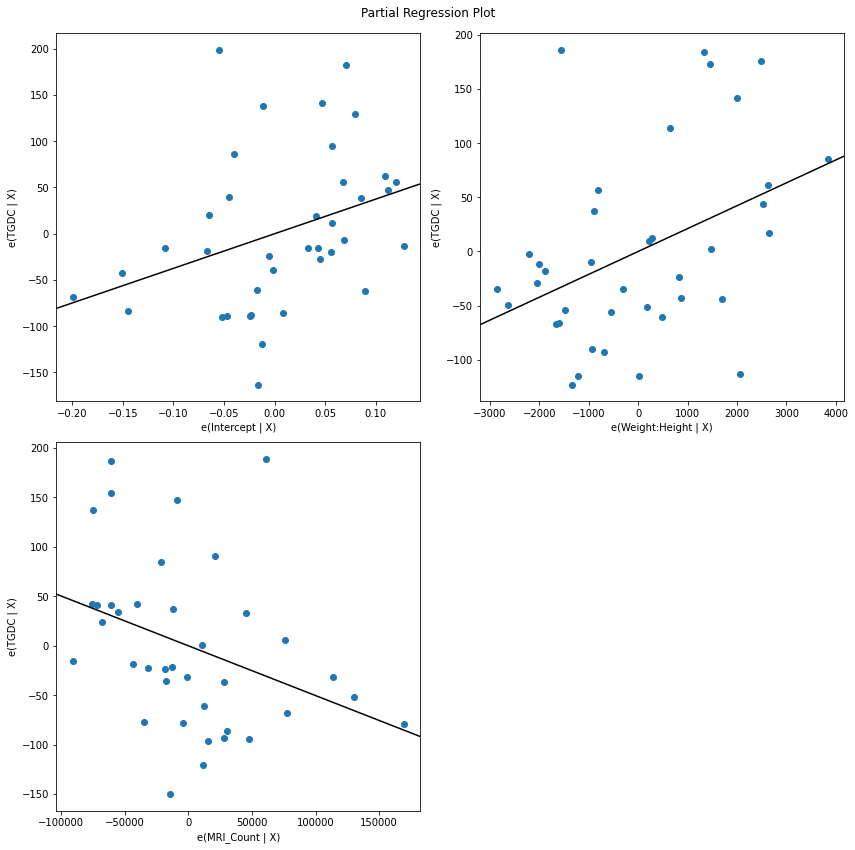

In [13]:
fig = plt.figure(figsize=(12,12))
fig = sm.graphics.plot_partregress_grid(model_fit, fig=fig)

plt.savefig('fig' + os.path.sep + 'regressors.png', bbox_inches='tight')

After ploting the regressors we can see that `Weight:Height` has a positive effect on `TGDC` while `MRI_Count` has a negative (all effects are <0.05)

We can see that our data have some outliers. We will optimize our exculsion critera using the z-score in the variables we are interested.

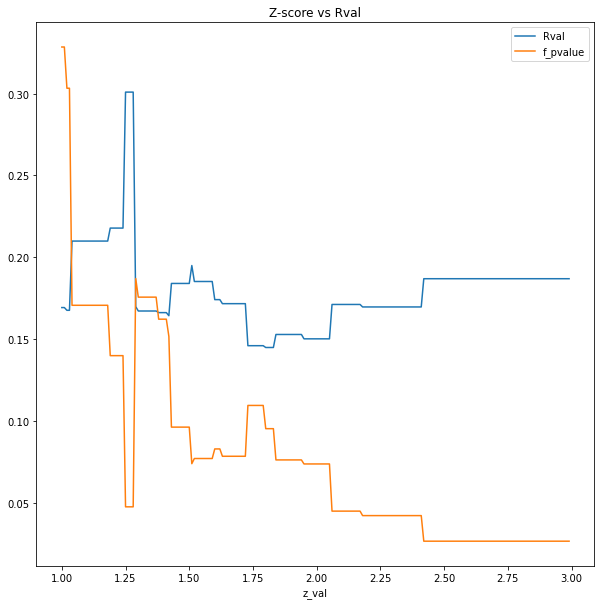

In [14]:
z_val = np.arange(1,3, 0.01)


inculded_vars = ['Height', 'Weight', 'MRI_Count']

df = pd.DataFrame(columns=['z_val', 'Rval', 'f_pvalue' ])


for val in z_val:
    
    z_s = np.abs(stats.zscore(data[inculded_vars]))
    dataf = data[(z_s < val).all(axis=1)]

    if dataf.shape[0] < 1:
        df = df.append( {'z_val':val, 'Rval':0, 'f_pvalue':0}, ignore_index=True)
        continue
    
    # Fit the model
    model= ols(super_model, dataf)

    rs = model.fit()
    
    df = df.append( {'z_val':val, 'Rval':rs.rsquared, 'f_pvalue':rs.f_pvalue}, ignore_index=True)
    
df.plot(x='z_val', y=['Rval', 'f_pvalue'], title='Z-score vs Rval', figsize=(10,10))

plt.savefig('fig' + os.path.sep + 'optimize-z-values.png', bbox_inches='tight')

In the previous graph we can see that removing outliers makes our model worse.

We can confirm that we don't need to remove any outliers in our sample. 

Another prove that our model really works to correctly explain our data.

In [15]:
# Code that can be use to filter the data base on a specific z

# z_s = np.abs(stats.zscore(data[inculded_vars]))
# dataf = data[(z_s < 1.27).all(axis=1)]
# model= ols(super_model, dataf)

# rs = model.fit()

# print(rs.summary())
# fig = plt.figure(figsize=(12,12))
# fig = sm.graphics.plot_partregress_grid(rs, fig=fig)

# Conculusion

Lucky we measure the TGCD (Get from the Chair to the Door).

We expect that we can generalize the previous very acurate model to explain our data. 

To our suprize... does not give any significant results.

We may need to model in a different way this problem.

                            OLS Regression Results                            
Dep. Variable:                   TGCD   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.047
Method:                 Least Squares   F-statistic:                    0.1677
Date:                Sun, 31 May 2020   Prob (F-statistic):              0.846
Time:                        23:17:21   Log-Likelihood:                -222.11
No. Observations:                  38   AIC:                             450.2
Df Residuals:                      35   BIC:                             455.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       164.3721    183.016      0.898

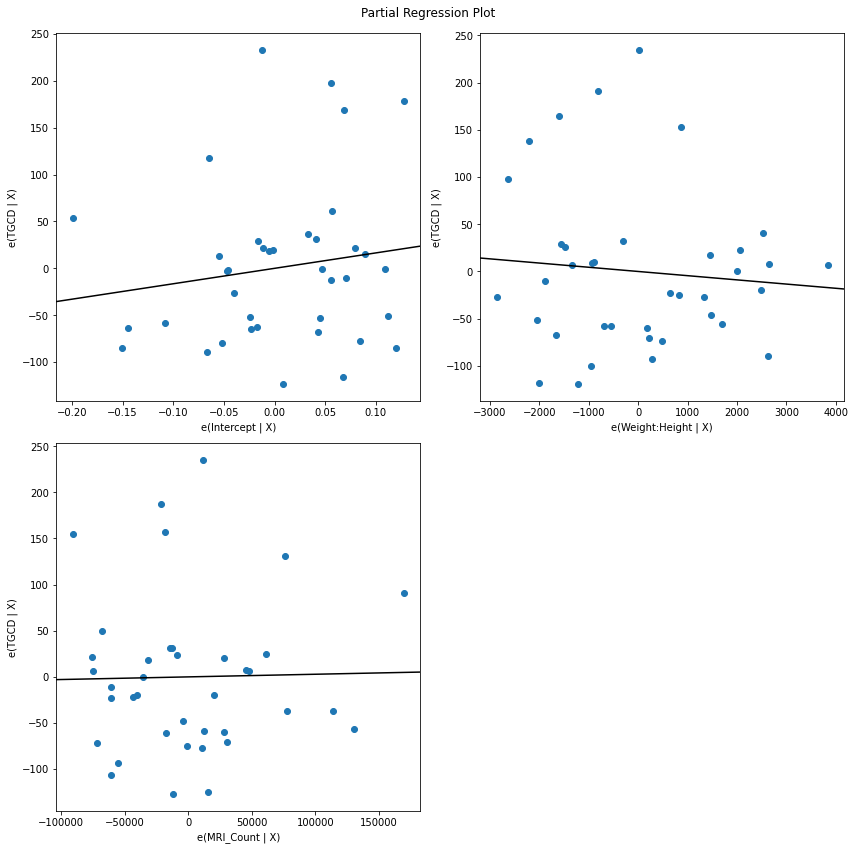

In [16]:
# z_s = np.abs(stats.zscore(data[inculded_vars]))

# dataf = data[(z_s < 1.56).all(axis=1)]
# model= ols(super_model2, dataf)
model= ols(super_model2, data)

rs = model.fit()

print(rs.summary())
fig = plt.figure(figsize=(12,12))
fig = sm.graphics.plot_partregress_grid(rs, fig=fig)